In [1]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/misinformation-fake-news-text-dataset-79k/EXTRA_RussianPropagandaSubset.csv
/kaggle/input/misinformation-fake-news-text-dataset-79k/DataSet_Misinfo_TRUE.csv
/kaggle/input/misinformation-fake-news-text-dataset-79k/DataSet_Misinfo_FAKE.csv


In [2]:
df_fake = pd.read_csv('/kaggle/input/misinformation-fake-news-text-dataset-79k/DataSet_Misinfo_FAKE.csv')
df_true = pd.read_csv('/kaggle/input/misinformation-fake-news-text-dataset-79k/DataSet_Misinfo_TRUE.csv')
dfr = pd.read_csv('/kaggle/input/misinformation-fake-news-text-dataset-79k/EXTRA_RussianPropagandaSubset.csv')

# Data Cleaning

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import spacy
from textblob import TextBlob
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_fake.drop_duplicates(inplace=True)

In [5]:
df_true['label']=1
df_true=df_true.drop('Unnamed: 0',axis=1)
df_fake['label']=0
df_fake=df_fake.drop('Unnamed: 0',axis=1)

df = pd.concat([df_true, df_fake])

In [6]:
df.head()

,text,label
0,The head of a conservative Republican faction ...,1
1,Transgender people will be allowed for the fir...,1
2,The special counsel investigation of links bet...,1
3,Trump campaign adviser George Papadopoulos tol...,1
4,President Donald Trump called on the U.S. Post...,1


In [7]:
df.dropna(subset=['text'], inplace=True)
df['text'] = df['text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))
df['text'] = df['text'].apply(lambda x: x.lower())
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x))

In [8]:
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda x: [stemmer.stem(word) for word in x])
df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x))
df['text'] = df['text'].apply(lambda x: re.sub('\d+', '', x))

In [9]:
extraction = spacy.load('en_core_web_sm')

def info(text):
    if isinstance(text, str):
        doc = extraction(text)
        country = ""
        org = ""
        person = ""
        for ent in doc.ents:
            if ent.label_ == "GPE":
                if not country:
                    country = ent.text
            elif ent.label_ == "ORG":
                if not org:
                    org = ent.text
            elif ent.label_ == "PERSON":
                if not person:
                    person = ent.text
        return pd.Series({'Country': country, 'Organization': org, 'Person': person})
    else:
        return pd.Series({'Country': "", 'Organization': "", 'Person': ""})

df[['Country', 'Organization', 'Person']] = df['text'].apply(info)

In [10]:
df.head()

,text,label,Country,Organization,Person
0,head conserv republican faction us congress vo...,1,urg,congress,donald trump
1,transgend peopl allow first time enlist us mil...,1,washington,pentagon,us militari
2,special counsel investig link russia presid tr...,1,russia,fbi,graham serv senat arm forc judiciari committe
3,trump campaign advis georg papadopoulo told au...,1,new york,fbi,russia polit
4,presid donald trump call us postal servic frid...,1,washington,bloomberg news bezo,presid donald trump


In [11]:
def count_words(text):
    if isinstance(text, str):
        return len(text.split())-2
    else:
        return 0
df['Count'] = df['text'].apply(count_words)

In [31]:
df.head()

,text,label,Country,Organization,Person,Count
0,head conserv republican faction us congress vo...,1,urg,congress,donald trump,435
1,transgend peopl allow first time enlist us mil...,1,washington,pentagon,us militari,231
2,special counsel investig link russia presid tr...,1,russia,fbi,graham serv senat arm forc judiciari committe,258
3,trump campaign advis georg papadopoulo told au...,1,new york,fbi,russia polit,223
4,presid donald trump call us postal servic frid...,1,washington,bloomberg news bezo,presid donald trump,482


In [12]:
grouped = df.groupby(['label', 'Person','Organization'])
counts = grouped.size()
top_15_counts = counts.sort_values(ascending=False).head(15)
top_15_df = pd.DataFrame({'counts': top_15_counts.values}, index=top_15_counts.index)

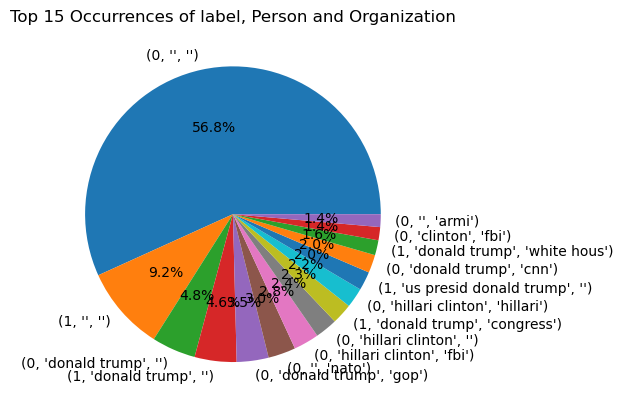

In [13]:
import matplotlib.pyplot as plt
plt.pie(top_15_df['counts'], labels=top_15_df.index, autopct='%1.1f%%')
plt.title('Top 15 Occurrences of label, Person and Organization')
plt.show()

In [14]:
grouped = df.groupby(['Country', 'Organization', 'Person'])
counts = grouped.size()
top_10_counts = counts.sort_values(ascending=False).head(15)
top_10_df = pd.DataFrame({'counts': top_10_counts.values}, index=top_10_counts.index)


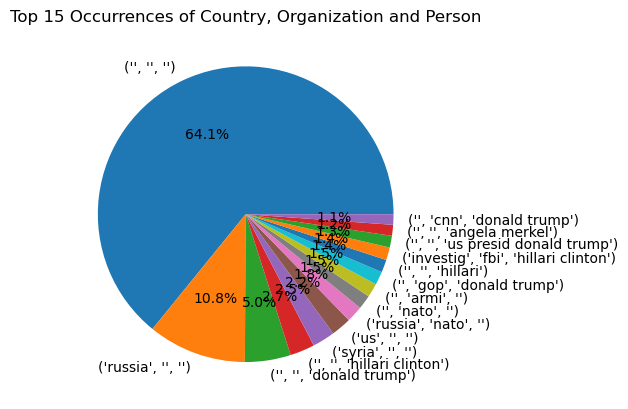

In [15]:
import matplotlib.pyplot as plt
plt.pie(top_10_df['counts'], labels=top_10_df.index, autopct='%1.1f%%')
plt.title('Top 15 Occurrences of Country, Organization and Person')
plt.show()

In [16]:
top_10_df

counts
Country  Organization Person                        
                                                2907
russia                                           488
                      donald trump               227
                      hillari clinton            122
syria                                            112
us                                               100
russia   nato                                     81
         nato                                     70
         armi                                     69
         gop          donald trump                66
                      hillari                     63
investig fbi          hillari clinton             63
                      us presid donald trump      58
                      angela merkel               54
         cnn          donald trump                52

In [17]:
x = df.drop('label', axis = 1)
y = df['label']

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [19]:
voc_size=5000

In [20]:
messages=x.copy()
messages.reset_index(inplace=True)

In [21]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print(i)
    review = re.sub('[^a-zA-Z]', ' ', messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [22]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[140,
  4036,
  1516,
  72,
  1158,
  2534,
  2404,
  275,
  3165,
  1998,
  383,
  4579,
  3159,
  554,
  4308,
  2509,
  4457,
  4036,
  1709,
  306,
  1939,
  4272,
  4087,
  4031,
  4613,
  231,
  503,
  1516,
  1158,
  2560,
  4810,
  3294,
  206,
  2197,
  1328,
  383,
  1400,
  3870,
  1615,
  2947,
  2627,
  3452,
  3877,
  4299,
  2546,
  3329,
  3167,
  3397,
  3452,
  2108,
  3112,
  1046,
  2947,
  1939,
  1411,
  71,
  4001,
  7,
  3508,
  2104,
  1051,
  2342,
  2534,
  1257,
  957,
  628,
  1516,
  3011,
  4087,
  4404,
  2534,
  4732,
  4704,
  2602,
  1516,
  2316,
  4896,
  1939,
  4370,
  2963,
  2627,
  3820,
  4562,
  2316,
  2046,
  4370,
  4711,
  3261,
  2627,
  386,
  3808,
  2281,
  694,
  950,
  1294,
  4491,
  2594,
  4144,
  1480,
  2602,
  3776,
  1038,
  1441,
  2911,
  4370,
  4711,
  3261,
  2627,
  3614,
  3294,
  288,
  2743,
  3396,
  1764,
  314,
  2187,
  1891,
  386,
  3820,
  1441,
  892,
  736,
  1338,
  4329,
  3159,
  257,
  3614,
  4457,
  4

In [23]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[3327  483 3495 ... 1224 2404 3327]
 [3612 2104 1911 ...  294 2947 2748]
 [ 518  231 2855 ... 1158 2070 1891]
 ...
 [ 442 4219 2287 ... 1226 1182 1723]
 [ 442 4219 2287 ... 1226 1182 1723]
 [1182 2467 1158 ... 2467 4806 4035]]


In [24]:
embedded_docs[0]

array([3327,  483, 3495, 4887, 3566, 3187, 4264, 1112, 2109,  483, 2695,
       4111, 3634, 2027, 2602, 3776, 2709, 1224, 2404, 3327], dtype=int32)

In [25]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
voc_size=5000
sent_length=20
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33,random_state=42)

In [28]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
823/823 [==============================] - 31s 30ms/step - loss: 0.3341 - accuracy: 0.8500 - val_loss: 0.2727 - val_accuracy: 0.8856
Epoch 2/10
823/823 [==============================] - 8s 9ms/step - loss: 0.2380 - accuracy: 0.9036 - val_loss: 0.2687 - val_accuracy: 0.8863
Epoch 3/10
823/823 [==============================] - 7s 9ms/step - loss: 0.2026 - accuracy: 0.9203 - val_loss: 0.2753 - val_accuracy: 0.8862
Epoch 4/10
823/823 [==============================] - 7s 9ms/step - loss: 0.1703 - accuracy: 0.9338 - val_loss: 0.2951 - val_accuracy: 0.8864
Epoch 5/10
823/823 [==============================] - 6s 7ms/step - loss: 0.1412 - accuracy: 0.9460 - val_loss: 0.3092 - val_accuracy: 0.8827
Epoch 6/10
823/823 [==============================] - 7s 8ms/step - loss: 0.1153 - accuracy: 0.9578 - val_loss: 0.3591 - val_accuracy: 0.8856
Epoch 7/10
823/823 [==============================] - 6s 7ms/step - loss: 0.0940 - accuracy: 0.9656 - val_loss: 0.3970 - val_accuracy: 0.8837
Epoc

In [29]:
from tensorflow.keras.layers import Dropout
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])